In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pulp


In [2]:
"""
Maximal Profit from Photovoltaic System
"""
# Define the problem
prob = pulp.LpProblem("Maximize_Profit", pulp.LpMaximize)

# Define the decision variables to be vectors of k components

x = pulp.LpVariable.dicts("x", range(24*4), lowBound=0)  # Charge to sell from battery from previous day
y = pulp.LpVariable.dicts("y", range(24*4), lowBound=0)  # Charge to sell from solar panel
z = pulp.LpVariable.dicts("z", range(24*4), lowBound=0)  # Charge to sell from battery for current day 

A = np.random.randint(0, 100, 24*4) # Market price of electricity in 15 minute intervals
B = np.random.randint(0, 100, 24*4) # Panel output in 15 minute intervals

# Define the objective function

prob += pulp.lpSum([A[i]*(x[i] + y[i] + z[i]) for i in range(24*4)]), "Total Profit"

# Define the constraints
prob += pulp.lpSum([x[i] for i in range(24*4)]) <= 100, "max_charge_of_battery_x"
prob += pulp.lpSum([z[i] for i in range(24*4)]) <= 100, "max_charge_of_battery_z"
prob += pulp.lpSum([y[i] + z[i] for i in range(24*4)]) <= pulp.lpSum([B[i] for i in range(24*4)]), "max_production_capacity_of_solar_panel"

# Solve the problem
prob.solve()

# Print the results
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Optimal value of x (Remaining Charge of battery to sell): {sum(pulp.value(x[i]) for i in range(24*4))}")
print(f"Optimal value of y (Solar panel charge to sell): {sum(pulp.value(y[i]) for i in range(24*4))}")
print(f"Optimal value of z (Charge of Battery to sell): {sum(pulp.value(z[i]) for i in range(24*4))}")
print(f"Maximum Profit: {pulp.value(prob.objective)}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codespace/.python/current/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/83c39a93dcfd47e6ade0aec4d930fc4a-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/83c39a93dcfd47e6ade0aec4d930fc4a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 675 RHS
At line 679 BOUNDS
At line 680 ENDATA
Problem MODEL has 3 rows, 288 columns and 384 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-3) rows, 0 (-288) columns and 0 (-384) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 461439
After Postsolve, objective 461439, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 461439 - 0 iterations time 0.002, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wall

In [3]:
x_values = [pulp.value(x[i]) for i in range(24*4)]
y_values = [pulp.value(y[i]) for i in range(24*4)]
z_values = [pulp.value(z[i]) for i in range(24*4)]

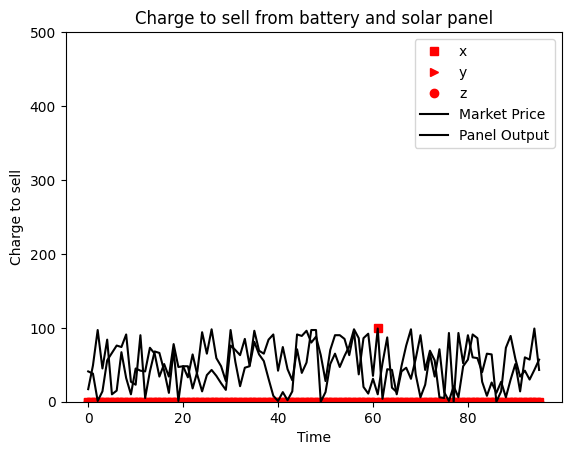

In [4]:
plt.plot(x_values, 'rs', label="x")
plt.plot(y_values, 'r>', label="y")
plt.plot(z_values, 'ro',label="z")
plt.plot(A, 'k',label="Market Price")
plt.plot(B, 'k', label="Panel Output")
plt.xlabel("Time")
plt.ylabel("Charge to sell")
plt.ylim(0, 500)
plt.title("Charge to sell from battery and solar panel")
plt.legend()    

In [13]:
from scipy.optimize import linprog

# Define the problem

num_intervals = 24*4

x = np.zeros(num_intervals) # Charge to sell from solar panel
y = np.zeros(num_intervals) # Charge to sell from battery from previous day 
z = np.zeros(num_intervals) # Charge to sell from battery for current day


num_variables = num_intervals*3  # 24 hours, 4 15-minute intervals, 3 variables types
num_constrains = num_intervals + 3  # constraints

# Objective function coefficients (for maximization, flip signs)
A = np.random.randint(0, 100, num_intervals) # Market price of electricity in 15 minute intervals
B = np.random.randint(0, 100, num_intervals) # Panel output in 15 minute intervals
C = 30 # Battery charge from previous day
C1 = 50 # Battery charge cappacity

c = np.concatenate((A, A, A))

# Inequality constraint coefficients (Ax <= b)

A_ = np.zeros((num_constrains, num_variables))

"""
Adding constraints
"""
b = [C, np.sum(B), C1]  # Right-hand side of the inequalities
for i in range(num_intervals):
    A_[0, num_intervals + i] = 1 # Charge to sell from battery from previous day cannot exceed the battery charge from previous day
    A_[1, num_intervals*2 + i] = 1 # Charge to sell from battery from present day cannot exceed the battery charge from previous day
    A_[1, i] = 1 # Charge to sell from panel + Charge to sell from battery from present day cannot exceed total panel output
    A_[2, num_intervals + i] = 1 # Charge to sell from battery from present day cannot exceed the battery charge from previous day
    A_[2, num_intervals*2 + i] = 1 # Charge to sell from battery from present day cannot exceed the battery charge from previous day
    A_[i+3, i] = 1 # Charge to sell from panel cannot exceed total panel output
    b.append(B[i])
# Bounds for each variable (None means no bound)
x_bounds = [(0, None) for i in range(24*4*3)]

# Solve the problem
result = linprog(-c, A_ub=A_, b_ub=b, bounds=x_bounds, method='highs')

# Print the results
if result.success:
    print("Optimal solution:", result.x)
    print("Maximum value:", -result.fun)  # Flip sign back for maximization
else:
    print("Optimization failed:", result.message)

Optimal solution: [ 5. 27. 89.  0.  4. 11. 17. 55. 36. 49. 31. 59.  4. 90. 78. 16. 25. 45.
 19.  4. 13. 21. 26. 64. 31. 29. 67. 69. 19. 67. 71. 31. 57. 10. 12. 34.
 18. 31. 77. 31. 90.  4. 66. 49. 38. 99. 60. 43. 10. 43. 99. 37. 27. 29.
 90. 10. 24. 17.  4. 55. 99. 72. 77. 69. 39. 54. 51. 91. 10. 66. 49. 20.
 13. 16. 74. 61. 94. 91. 41. 83. 78. 55. 33. 78. 94. 53. 18. 91. 65. 70.
 87.  1. 64. 40. 28. 87.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. 50.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. 

In [3]:
np.transpose(A_) @ b

array([4655., 4630., 4668., 4636., 4717., 4663., 4669., 4661., 4635.,
       4663., 4666., 4691., 4707., 4711., 4720., 4691., 4665., 4710.,
       4633., 4703., 4654., 4672., 4722., 4708., 4680., 4696., 4696.,
       4701., 4646., 4672., 4674., 4707., 4668., 4661., 4645., 4660.,
       4721., 4638., 4652., 4685., 4713., 4654., 4680., 4678., 4711.,
       4672., 4682., 4685., 4692., 4714., 4672., 4729., 4712., 4702.,
       4685., 4678., 4698., 4674., 4671., 4690., 4690., 4639., 4641.,
       4705., 4682., 4644., 4632., 4644., 4659., 4637., 4663., 4719.,
       4654., 4712., 4636., 4650., 4667., 4634., 4726., 4644., 4720.,
       4640., 4721., 4673., 4693., 4726., 4667., 4640., 4724., 4692.,
       4715., 4725., 4693., 4674., 4630., 4655.,   39.,   39.,   39.,
         39.,   39.,   39.,   39.,   39.,   39.,   39.,   39.,   39.,
         39.,   39.,   39.,   39.,   39.,   39.,   39.,   39.,   39.,
         39.,   39.,   39.,   39.,   39.,   39.,   39.,   39.,   39.,
         39.,   39.,

In [11]:
(A_ @ result.x) <= b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [6]:
b

[np.int64(39),
 np.int64(4630),
 np.int64(25),
 np.int64(0),
 np.int64(38),
 np.int64(6),
 np.int64(87),
 np.int64(33),
 np.int64(39),
 np.int64(31),
 np.int64(5),
 np.int64(33),
 np.int64(36),
 np.int64(61),
 np.int64(77),
 np.int64(81),
 np.int64(90),
 np.int64(61),
 np.int64(35),
 np.int64(80),
 np.int64(3),
 np.int64(73),
 np.int64(24),
 np.int64(42),
 np.int64(92),
 np.int64(78),
 np.int64(50),
 np.int64(66),
 np.int64(66),
 np.int64(71),
 np.int64(16),
 np.int64(42),
 np.int64(44),
 np.int64(77),
 np.int64(38),
 np.int64(31),
 np.int64(15),
 np.int64(30),
 np.int64(91),
 np.int64(8),
 np.int64(22),
 np.int64(55),
 np.int64(83),
 np.int64(24),
 np.int64(50),
 np.int64(48),
 np.int64(81),
 np.int64(42),
 np.int64(52),
 np.int64(55),
 np.int64(62),
 np.int64(84),
 np.int64(42),
 np.int64(99),
 np.int64(82),
 np.int64(72),
 np.int64(55),
 np.int64(48),
 np.int64(68),
 np.int64(44),
 np.int64(41),
 np.int64(60),
 np.int64(60),
 np.int64(9),
 np.int64(11),
 np.int64(75),
 np.int64(52),

In [8]:
A

array([ 7, 15, 83, 77, 30, 66, 45, 10, 32, 59, 45, 24, 33,  6, 94,  7, 93,
       75, 13,  1, 47, 52, 61, 85, 45, 65, 69,  9, 23, 38, 44, 67, 16, 77,
       48, 92, 94, 18, 61, 46, 36, 65,  2, 28, 67, 32, 89, 33, 16, 45,  2,
       29, 37, 29, 63, 87, 48,  6, 23, 64,  1, 82,  5, 96, 76, 35, 35, 26,
       65, 91,  9, 53, 63,  8, 32, 49, 35, 98, 17, 33, 80, 16, 14, 92, 28,
       89, 79, 78, 52, 51, 19, 58, 56, 46,  4, 46])

In [12]:
C

89

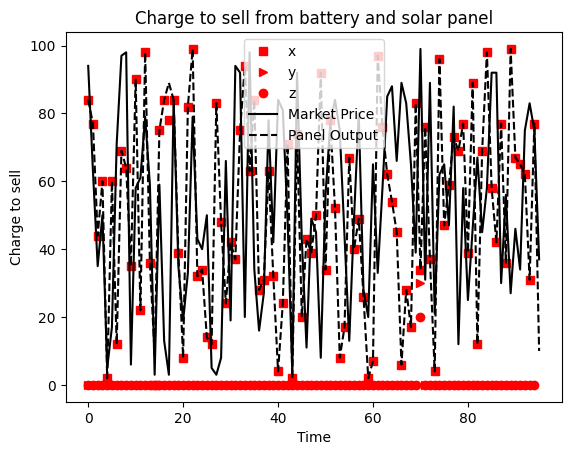

In [11]:
plt.plot(results.x[0:24*4-1], 'rs', label="x")
plt.plot(results.x[24*4:24*4*2-1], 'r>', label="y")
plt.plot(results.x[24*4*2:-1], 'ro',label="z")
plt.plot(A, 'k',label="Market Price")
plt.plot(B, 'k--', label="Panel Output")
plt.xlabel("Time")
plt.ylabel("Charge to sell")
#plt.ylim(0, 500)
plt.title("Charge to sell from battery and solar panel")
plt.legend()    

In [8]:
import optimization
import numpy as np 
import matplotlib.pyplot as plt

In [6]:
num_intervals = 24*4
A = np.random.randint(0, 100, num_intervals) # Market price of electricity in 15 minute intervals
B = np.random.randint(0, 100, num_intervals) # Panel output in 15 minute intervals
C = 30 # Battery charge from previous day
C1 = 50 # Battery charge cappacity

results = optimization.optimize_portfolio(num_intervals, A, B, C, C1)